In [ ]:
!wget https://drive.google.com/file/d/1BRhlDz-JASvfEljf_XxrL-ZH4gUvOg0v/view

--2023-06-29 00:36:06--  https://drive.google.com/file/d/1BRhlDz-JASvfEljf_XxrL-ZH4gUvOg0v/view
Resolving drive.google.com (drive.google.com)... 142.250.31.100, 142.250.31.102, 142.250.31.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.31.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view’

view                    [ <=>                ]  77.93K  --.-KB/s    in 0.001s  

2023-06-29 00:36:06 (76.7 MB/s) - ‘view’ saved [79804]



In [2]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393430 sha256=96195d45bdeafa60a1dadbb7b5f549e5c18ea376b4339618a6a421b96aac9e90
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize
import string
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
import fasttext
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from torch.optim import Adam

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from time import time
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [4]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Reading and Preproccessing the data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/ML_NLP/data-train.csv')

In [8]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [9]:
df.drop('PhraseId', axis=1, inplace=True)

In [10]:
df.head()

,SentenceId,Phrase,Sentiment
0,1,A series of escapades demonstrating the adage ...,1
1,1,A series of escapades demonstrating the adage ...,2
2,1,A series,2
3,1,A,2
4,1,series,2


This function below is for preprocessing the data

In [11]:
def preprocess_text(text, minimum_length=1, stopword_removal=False, stopwords_domain=[], lower_case=True,
                       punctuation_removal=True):

    normalized_tokens = word_tokenize(text)
    if stopword_removal:
        stopwords = [x.lower() for x in nltk.corpus.stopwords.words('english')]
        domain_stopwords = [x.lower() for x in stopwords_domain]
        normalized_tokens = [word for word in normalized_tokens if word.lower() not in domain_stopwords + stopwords]

    if punctuation_removal:
        normalized_tokens = [word for word in normalized_tokens if word not in string.punctuation]

    if lower_case:
        normalized_tokens = [word.lower() for word in normalized_tokens if len(word) > minimum_length]
    else:
        normalized_tokens = [word for word in normalized_tokens if len(word) > minimum_length]

    return normalized_tokens

In [12]:
df['Process Phrase'] = df['Phrase'].apply(lambda x: preprocess_text(x))

In [13]:
df.head()

,SentenceId,Phrase,Sentiment,Process Phrase
0,1,A series of escapades demonstrating the adage ...,1,"[series, of, escapades, demonstrating, the, ad..."
1,1,A series of escapades demonstrating the adage ...,2,"[series, of, escapades, demonstrating, the, ad..."
2,1,A series,2,[series]
3,1,A,2,[]
4,1,series,2,[series]


In [14]:
df.drop('Phrase', axis=1, inplace=True)

In [15]:
df = df[df['Process Phrase'].str.len() > 0]


In [16]:
df.head()

,SentenceId,Sentiment,Process Phrase
0,1,1,"[series, of, escapades, demonstrating, the, ad..."
1,1,2,"[series, of, escapades, demonstrating, the, ad..."
2,1,2,[series]
4,1,2,[series]
5,1,2,"[of, escapades, demonstrating, the, adage, tha..."


In [17]:
df.drop('SentenceId', axis=1, inplace=True)

In [18]:
df.head(50)

,Sentiment,Process Phrase
0,1,"[series, of, escapades, demonstrating, the, ad..."
1,2,"[series, of, escapades, demonstrating, the, ad..."
2,2,[series]
4,2,[series]
5,2,"[of, escapades, demonstrating, the, adage, tha..."
6,2,[of]
7,2,"[escapades, demonstrating, the, adage, that, w..."
8,2,[escapades]
9,2,"[demonstrating, the, adage, that, what, is, go..."
10,2,"[demonstrating, the, adage]"


In [19]:
x = df['Process Phrase']
y = df['Sentiment']

In [20]:
type(x)

pandas.core.series.Series

In [21]:
class FastText:

    def __init__(self, preprocessor=None, method='skipgram'):
        self.method = method
        self.model = None
        self.preprocessor = preprocessor

    def train(self, texts):
        """
        train the fasttext model and save it into self.model
        Parameters
        ----------
        texts: list of list of str
        """
        with open('train.txt', 'w') as f:
            for text in texts:
                f.write(" ".join(text) + "\n")
        self.model = fasttext.train_unsupervised('train.txt', model=self.method, dim=100)

    def get_query_embedding(self, query, tf_idf_vectorizer):
        """
        get the embedding of the query. You can use the tf_idf_vectorizer to get the weights of the words in the query. preprocess the query using self.preprocessor if it is not None
        Parameters
        ----------
        query: str
        tf_idf_vectorizer: TfidfVectorizer
        Returns embedding of the query
        """

        query_embed = self.model.get_word_vector(query)
        return query_embed

    def save_FastText_model(self, path='FastText_model.bin'):
        self.model.save_model(path)

    def load_FastText_model(self, path="FastText_model.bin"):
        self.model = fasttext.load_model(path)

    def prepare(self, dataset, mode, save=False):
        if mode == 'train':
            self.train(dataset)
        if mode == 'load':
            self.load_FastText_model()
        if save:
            self.save_FastText_model()

In [22]:
FastText_model = FastText(preprocessor=preprocess_text)
FastText_model.prepare(df['Process Phrase'], mode='train', save=True)

Here we do feature extraction.

In [23]:
embeddings = []
for row in df['Process Phrase']:
    embeddings.append(FastText_model.model.get_word_vector(' '.join(row)))
embeddings = np.array(embeddings)

In [24]:
embeddings.shape

(154966, 100)

In [25]:
embeddings

array([[-0.05669227,  0.1250417 , -0.01385036, ...,  0.08043051,
         0.04662313,  0.01908301],
       [ 0.02847229,  0.05180153, -0.01982814, ...,  0.04347895,
         0.05504334,  0.04000985],
       [ 0.46918046,  0.0154562 ,  0.53942025, ..., -0.05166132,
         0.49163085,  0.12726252],
       ...,
       [-0.3032662 ,  0.13546728, -0.08002806, ...,  0.3985732 ,
         0.27305293, -0.1818879 ],
       [-0.3032662 ,  0.13546728, -0.08002806, ...,  0.3985732 ,
         0.27305293, -0.1818879 ],
       [-0.36756405,  0.19199874, -0.14434896, ...,  0.5135153 ,
         0.31290984, -0.22737812]], dtype=float32)

In [26]:
reviews = df['Process Phrase']
sentiment = df['Sentiment']

In [27]:
sentiment

0         1
1         2
2         2
4         2
5         2
         ..
155043    4
155044    2
155045    3
155046    4
155047    4
Name: Sentiment, Length: 154966, dtype: int64

In [28]:
type(sentiment)

pandas.core.series.Series

In [29]:
labels_df = sentiment.to_numpy()


In [30]:
labels_df

array([1, 2, 2, ..., 3, 4, 4])

In [31]:
# todo calculate the labels
enc = OneHotEncoder()
labels = enc.fit_transform(labels_df.reshape(-1, 1)).toarray()

In [32]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

Split data to train, test and validation

In [33]:
# todo split the data into train, val, test and create dataloaders
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)


  creat neural network model and train it

In [35]:
class PapersDataSet(Dataset):
    def __init__(self, embeddings: list, labels: list):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.embeddings[i], self.labels[i]

In [36]:

train_dataset = PapersDataSet(X_train, y_train)
test_dataset = PapersDataSet(X_test, y_test)
valid_dataset = PapersDataSet(X_valid, y_valid)

batch_size  = 64

train_loader = DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                                          batch_size=batch_size)

val_loader = DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size)

In [37]:
X_train.shape

(125522, 100)

In [38]:
y_train.shape

(125522, 5)

In [39]:
X_test.shape

(15497, 100)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [42]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, in_features=1000, num_classes=5):
        super().__init__()
        self.seq = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 512),  # Additional linear layer
            nn.ReLU(),                     # Activation function
            nn.Linear(512, 256),            # Additional linear layer
            nn.ReLU(),                     # Activation function
            nn.Linear(256, num_classes),    # Final linear layer
            nn.Softmax(1),
        )

    def forward(self, x):
        return self.seq(x)

# Define the number of classes
num_classes = 5

# Create an instance of the ResNet-50 model
model = CNN(100,5)

In [43]:
model = model.to(device)

In [44]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [45]:
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    """
    Evaluate the model on the given dataloader. used for validation and test
    Parameters
    ----------
    model: nn.Module
    criterion: nn.Module
    dataloader: torch.utils.data.DataLoader
    test_mode: bool
        If True, the function will print 'Test' instead of 'Validation'
    Returns
    -------
    eval_loss: float
        The loss on the given dataloader
    predicted_labels: list
        The predicted labels
    true_labels: list
        The true labels
    f1_score_macro: float
        The f1 score on the given dataloader
    """
    eval_loss = 0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for i, (x, labels) in enumerate(dataloader):
            x, labels = x.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            outputs = model(x)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            predicted_targets = outputs.argmax(dim=1)
            truths = labels.argmax(dim=1)
            predicted_labels.extend(predicted_targets.detach().cpu())
            true_labels.extend(truths.detach().cpu())

    f1_score_macro = f1_score(true_labels, predicted_labels, average='macro')


    return eval_loss, predicted_labels, true_labels, f1_score_macro

In [46]:
"""
Train the model for num_epochs epochs
epoch_true and epoch_all are used to calculate the accuracy.
epoch_true is the number of correct predictions and epoch_all is the total number of predictions in the epoch
"""
num_epochs = 30

train_loss_arr, val_loss_arr = [], []
f1_macro_scores = []
f1_train_scores = []
for epoch in range(num_epochs):
    start_time = time()

    train_loss, val_loss = 0, 0
    epoch_all = 0
    epoch_true = 0
    predicted_labels = []
    true_labels = []

    model.train()

    for i, (x, labels) in enumerate(train_loader):
        x, labels = x.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted_targets = outputs.argmax(dim=1)
        truths = labels.argmax(dim=1)
        predicted_labels.extend(predicted_targets.detach().cpu())
        true_labels.extend(truths.detach().cpu())
        epoch_true += (predicted_targets == truths).sum().item()
        epoch_all += len(predicted_targets)

    f1_train_scores.append(f1_score(true_labels, predicted_labels, average='macro'))
    model.eval()
    val_loss, predicted_labels, true_labels, f1_score_macro = eval_epoch(model, criterion, val_loader)
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    f1_macro_scores.append(f1_score_macro)

    end_time = time()

    print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')
    print(f"[Epoch {epoch + 1}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}\t F1 score macro: {f1_score_macro}")

Epoch 1 finished in 17.01s
[Epoch 1]	Train Loss: 0.0217	Validation Loss: 0.0214	 F1 score macro: 0.2102898286213266
Epoch 2 finished in 17.84s
[Epoch 2]	Train Loss: 0.0214	Validation Loss: 0.0214	 F1 score macro: 0.2064245285835026
Epoch 3 finished in 17.44s
[Epoch 3]	Train Loss: 0.0214	Validation Loss: 0.0214	 F1 score macro: 0.22928816615319833
Epoch 4 finished in 17.86s
[Epoch 4]	Train Loss: 0.0214	Validation Loss: 0.0214	 F1 score macro: 0.21195092244773567
Epoch 5 finished in 17.73s
[Epoch 5]	Train Loss: 0.0214	Validation Loss: 0.0214	 F1 score macro: 0.2138377655986751
Epoch 6 finished in 19.35s
[Epoch 6]	Train Loss: 0.0214	Validation Loss: 0.0213	 F1 score macro: 0.22979223570734825
Epoch 7 finished in 17.72s
[Epoch 7]	Train Loss: 0.0214	Validation Loss: 0.0213	 F1 score macro: 0.22275529858679866
Epoch 8 finished in 17.65s
[Epoch 8]	Train Loss: 0.0214	Validation Loss: 0.0213	 F1 score macro: 0.22060356119032884
Epoch 9 finished in 18.36s
[Epoch 9]	Train Loss: 0.0214	Validation 

[]

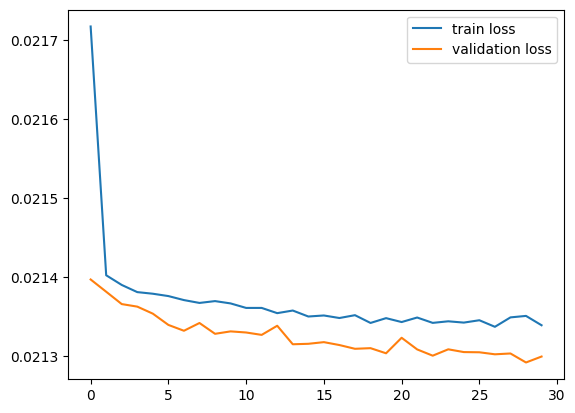

In [47]:
x = range(num_epochs)
plt.plot(x, train_loss_arr, label='train loss')
plt.plot(x, val_loss_arr, label='validation loss')
plt.legend()
plt.plot()

[]

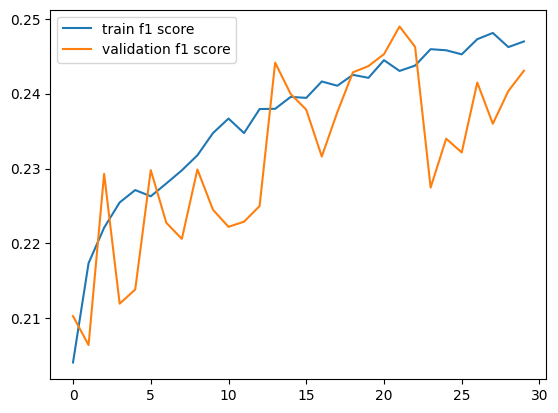

In [48]:
x = range(num_epochs)
plt.plot(x, f1_train_scores, label='train f1 score')
plt.plot(x, f1_macro_scores, label='validation f1 score')
plt.legend()
plt.plot()

In [49]:
model.eval()
eval_loss, predicted_labels, true_labels, f1_score_macro = eval_epoch(model, criterion, test_loader, test_mode=True)
eval_loss /= len(test_loader)
print(f"test loss: {eval_loss}")
print(f"accuracy: {accuracy_score(true_labels, predicted_labels)}")
print(f"f1 score macro: {f1_score(true_labels, predicted_labels, average='macro')}")
print(f"f1 score micro: {f1_score(true_labels, predicted_labels, average='micro')}")
print(f"average precision micro: {precision_score(true_labels, predicted_labels, average='micro')}")
print(f"average precision macro: {precision_score(true_labels, predicted_labels, average='macro')}")
print(f"average recall micro: {recall_score(true_labels, predicted_labels, average='micro')}")
print(f"average recall macro: {recall_score(true_labels, predicted_labels, average='macro')}")

test loss: 1.367424667617421
accuracy: 0.5254565399754791
f1 score macro: 0.23736900757990131
f1 score micro: 0.5254565399754791
average precision micro: 0.5254565399754791
average precision macro: 0.4471823650985784
average recall micro: 0.5254565399754791
average recall macro: 0.2524185521788179


Using SVM method

At first, we changed y into onehot encoded version and now we have to turn it back using next 2 blocks

In [36]:
indices = np.argmax(y_train, axis=1)

# Create a new array with the same length as output_array, filled with zeros
result_array = np.zeros(len(y_train))

# Iterate over each row in output_array
for i in range(y_train.shape[0]):
    # Get the index of the maximum value for the current row
    row_indices = np.argmax(y_train[i])

    # Set the index in the current row to 1
    result_array[i] = row_indices

# Print the result_array
print(result_array)

[2. 3. 1. ... 0. 1. 2.]


In [37]:
indices = np.argmax(y_test, axis=1)

# Create a new array with the same length as output_array, filled with zeros
result_array_test = np.zeros(len(y_test))

# Iterate over each row in output_array
for i in range(y_test.shape[0]):
    # Get the index of the maximum value for the current row
    row_indices = np.argmax(y_test[i])

    # Set the index in the current row to 1
    result_array_test[i] = row_indices

# Print the result_array
print(result_array_test)

[1. 1. 3. ... 0. 3. 2.]


In [55]:
X_train.shape

(125522, 100)

In [57]:
X_train

array([[-0.21086854,  0.18309726, -0.17156498, ..., -0.11361155,
         0.34971735,  0.4366246 ],
       [-0.06302486,  0.05618501, -0.11423474, ...,  0.1675095 ,
         0.05637605, -0.08395565],
       [-0.15354742,  0.10942771, -0.23730597, ...,  0.3448028 ,
        -0.14253844,  0.07123603],
       ...,
       [ 0.1694377 , -0.02895537, -0.12119164, ...,  0.03424437,
         0.02503991, -0.05662288],
       [ 0.00932727,  0.07561471, -0.00618562, ...,  0.01683664,
         0.04733503, -0.06816449],
       [-0.06240552,  0.04210282, -0.04881804, ..., -0.02833827,
        -0.01332827, -0.0644822 ]], dtype=float32)

In [56]:
result_array.shape

(125522,)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Train a linear support vector classifier (SVC)
classifier = SVC()
classifier.fit(X_train, result_array)


In [ ]:
# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

using *MultinomialNB*

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [38]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
mnb_model = mnb.fit(X_scaled, result_array)
print(mnb_model)
#fitting the svm for tfidf features
y_pred = mnb_model.predict(X_test)

# Evaluate the model
print(classification_report(result_array_test, y_pred))


MultinomialNB()
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       697
         1.0       0.00      0.00      0.00      2771
         2.0       0.51      1.00      0.68      7898
         3.0       0.00      0.00      0.00      3260
         4.0       0.00      0.00      0.00       871

    accuracy                           0.51     15497
   macro avg       0.10      0.20      0.14     15497
weighted avg       0.26      0.51      0.34     15497



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


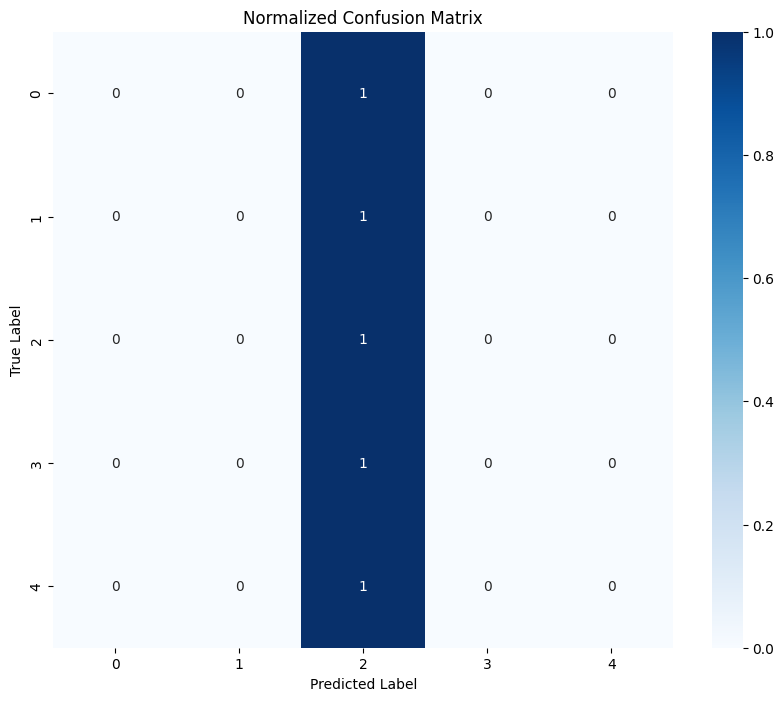

In [40]:
cm = confusion_matrix(result_array_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()